## Import packages

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi_edit as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 14,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure")#, dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import matplotlib.pyplot as plt

In [5]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

In [6]:
log10masses = np.linspace(14, 15.5, num = 2)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [7]:
lower = np.array([0.1125, 0.65])
upper = np.array([0.1275, 0.85])
prior = priors.Uniform(lower, upper)

In [8]:
theta_fiducial = np.array([0.1197, 0.76])
mass_calibration_param_names = ['\\alpha_{Y}', '\\beta_{Y}', '\\gamma_{Y}', 'Y_{*}', 'M_{*}', 
                                '\\alpha_{\sigma}', '\\gamma_{\sigma}', '\\sigma_{log Y_{0}}']

theta_fiducial_mass_calibration = np.array([1.8, 0., 0., 2.4e-10, 1e14, 0., 0., 0.127])

In [9]:
theta_fiducial_total = np.concatenate((theta_fiducial, theta_fiducial_mass_calibration))

In [10]:
N_countsSimulator = n_counts_simulator.Model(log10masses, z_min, z_max)
N_counts = N_countsSimulator.N_counts
#N_counts = N_countsSimulator.simulation(theta_fiducial, 1)
N_counts

array([22926.84511865, 68010.58076614, 85143.87570284, 74152.91292208,
       51774.03079771])

In [11]:
t1 = time.process_time()
N_countsSimulator.simulation(theta_fiducial, 1)
t2 = time.process_time()
print('time per 1 sim: '+ str(t2-t1))

time per 1 sim: 0.31368180200000007


## Version 1

(1) Compute fiducial number of counts N for redshift bins (for a range of masses, 14 to 15.5)

(2) Draw N samples from uniformly distributed redshift bins

(3) Draw masses for every redshift

(4) Create mock catalogue

In [43]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v1_Y500_2 as n_counts_simulator_1

In [44]:
importlib.reload(n_counts_simulator_1)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v1_Y500_2' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params_mock_catalogue_v1_Y500_2.py'>

In [45]:
N_countsSimulator1 = n_counts_simulator_1.Model(log10masses, z_min, z_max)

In [46]:
N_countsSimulator1.N_counts

(array([ 7487.26774769, 22519.00909962, 27996.24759731, 23465.767297  ,
        15226.37143005]),
 pyccl.Cosmology(Omega_c=0.25141776937618154, Omega_b=0.04667086746481833, h=0.69, n_s=0.9655, sigma8=0.76, A_s=None, Omega_k=0, Omega_g=0, Neff=0, w0=-1, wa=0, T_CMB=2.7, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='bbks', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker', halo_concentration='duffy2008', emulator_neutrinos='strict'))

In [47]:
t1 = time.process_time()
zY_500_pairs = N_countsSimulator1.simulation(theta_fiducial_total, 5)
t2 = time.process_time()
print('time per 1 sim: ' + str(t2 - t1))

time per 1 sim: 1.9556947869999988


In [48]:
zY_500_pairs

array([[1.22122122e-01, 3.36355343e-10],
       [1.87087087e-01, 1.45764586e-11],
       [1.20620621e-01, 3.09393945e-11],
       ...,
       [9.45245245e-01, 9.25665991e-13],
       [9.79679680e-01, 8.24465447e-13],
       [9.23323323e-01, 4.17128176e-13]])

In [49]:
pairs_by_z = [zY_500_pairs[(zY_500_pairs[:, 0] >= z_min[i]) & (zY_500_pairs[:, 0] <= z_max[i])] for i in range(len(z_min))]

In [59]:
n_bins = 10
Y_bins_limits = [np.logspace(np.log10(2e-12), np.log10(4e-9), num = n_bins),
                 np.logspace(np.log10(6e-13), np.log10(5.5e-10), num = n_bins),
                 np.logspace(np.log10(3e-13), np.log10(2.5e-10), num = n_bins),
                 np.logspace(np.log10(2e-13), np.log10(9e-11), num = n_bins),
                 np.logspace(np.log10(2e-13), np.log10(5e-11), num = n_bins)]


In [60]:
def get_counts_by_M(zY_500_pairs, M_bins = np.logspace(np.log10(2e-13), np.log10(4e-9), num = 5)):
    counts_by_M = [len(zY_500_pairs[(zY_500_pairs[:, 1] >= M_bins[i]) & (zY_500_pairs[:, 1] < M_bins[i + 1])]) 
                   for i in range(len(M_bins) - 1)]
    return counts_by_M

In [61]:
for i in range(5):
    print(get_counts_by_M(pairs_by_z[i], Y_bins_limits[i]))

[238, 2725, 2727, 1165, 426, 101, 28, 3, 0]
[982, 11059, 6516, 2652, 887, 241, 39, 4, 1]
[1075, 15054, 7895, 2900, 826, 210, 28, 3, 0]
[489, 12542, 7028, 2542, 774, 182, 30, 4, 0]
[2646, 7726, 3258, 1115, 310, 82, 11, 4, 0]


In [62]:
for i in range(5):
    print(np.amin(pairs_by_z[i][:, 1]))
    print(np.amax(pairs_by_z[i][:, 1]))
    print(np.sum(get_counts_by_M(pairs_by_z[i], Y_bins_limits[i])))
    print(pairs_by_z[i].shape)
    print(get_counts_by_M(pairs_by_z[i], Y_bins_limits[i]))
    print()

2.972230377133513e-12
1.3223588048319402e-09
7413
(7413, 2)
[238, 2725, 2727, 1165, 426, 101, 28, 3, 0]

7.923105603691203e-13
2.7376880644524353e-10
22381
(22381, 2)
[982, 11059, 6516, 2652, 887, 241, 39, 4, 1]

4.2375570280156314e-13
9.085367133028862e-11
27991
(27991, 2)
[1075, 15054, 7895, 2900, 826, 210, 28, 3, 0]

2.855569995170611e-13
4.323827889357089e-11
23591
(23591, 2)
[489, 12542, 7028, 2542, 774, 182, 30, 4, 0]

2.2186755787922276e-13
2.0002262793327027e-11
15152
(15152, 2)
[2646, 7726, 3258, 1115, 310, 82, 11, 4, 0]



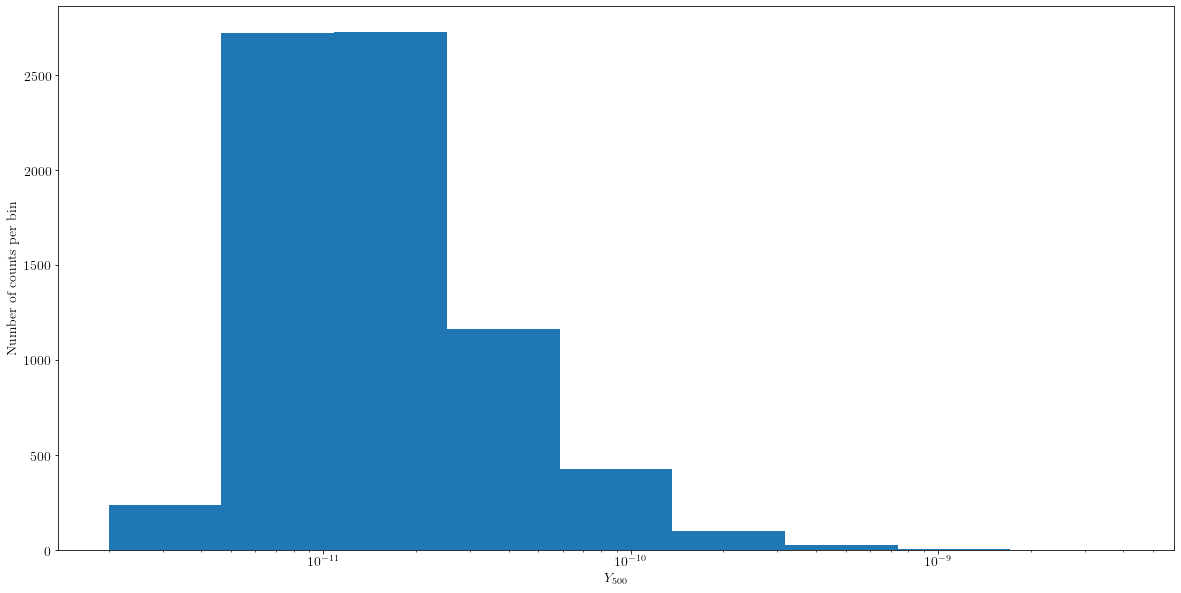

In [63]:
plt.figure(figsize=(20,10))
plt.hist(pairs_by_z[0][:, 1], bins=Y_bins_limits[0])
plt.gca().set_xscale("log")
plt.xlabel(r'$Y_{500}$')
plt.ylabel('Number of counts per bin')
plt.show()

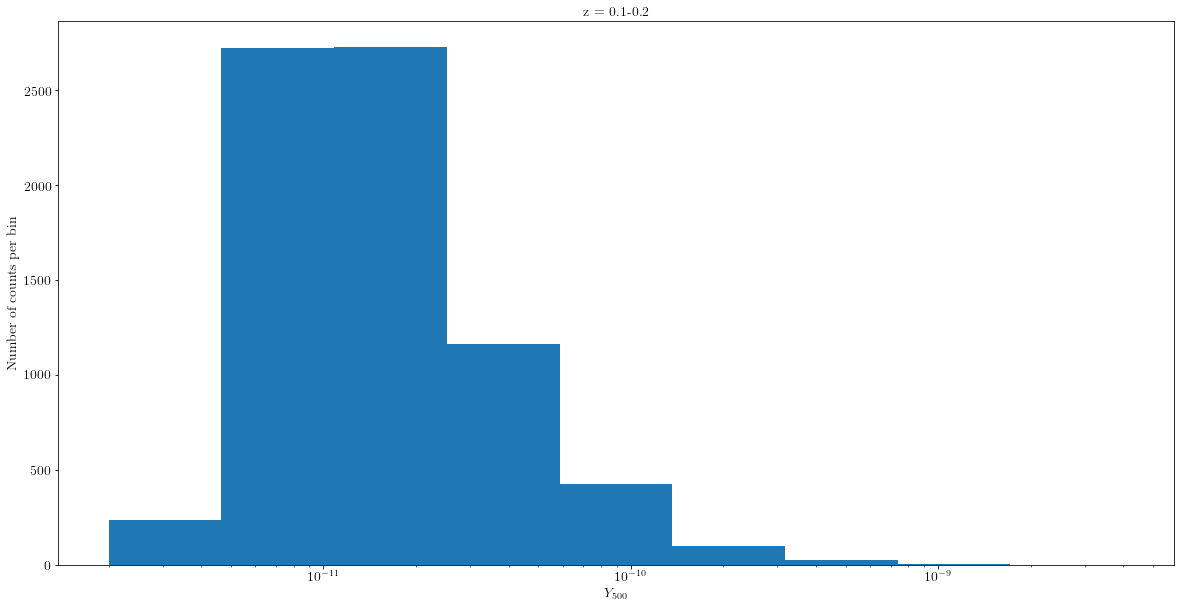

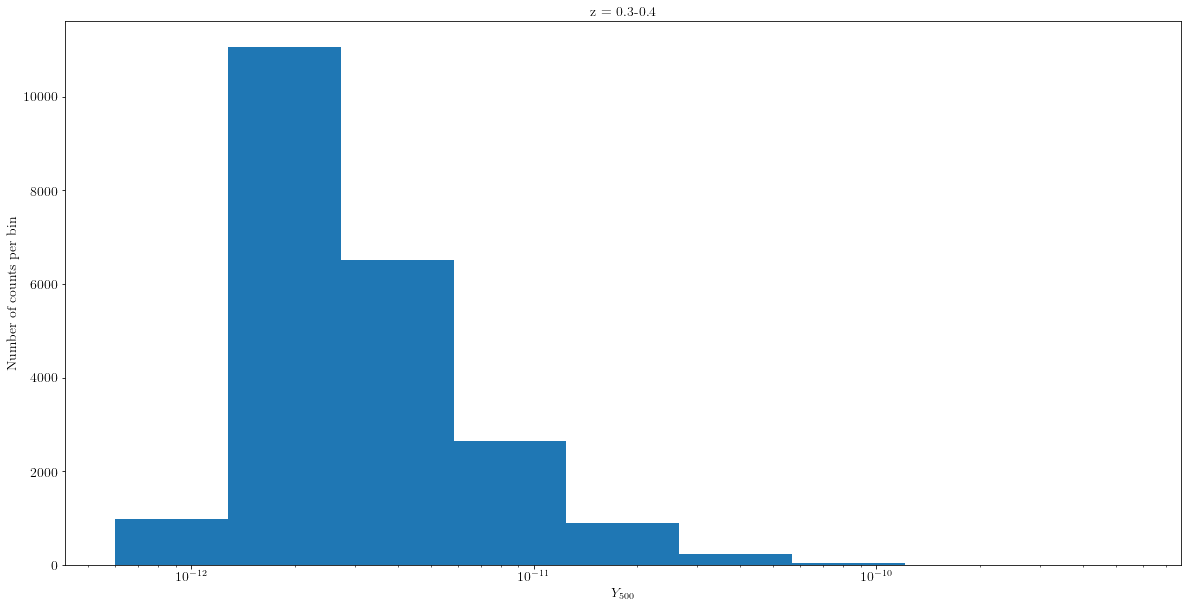

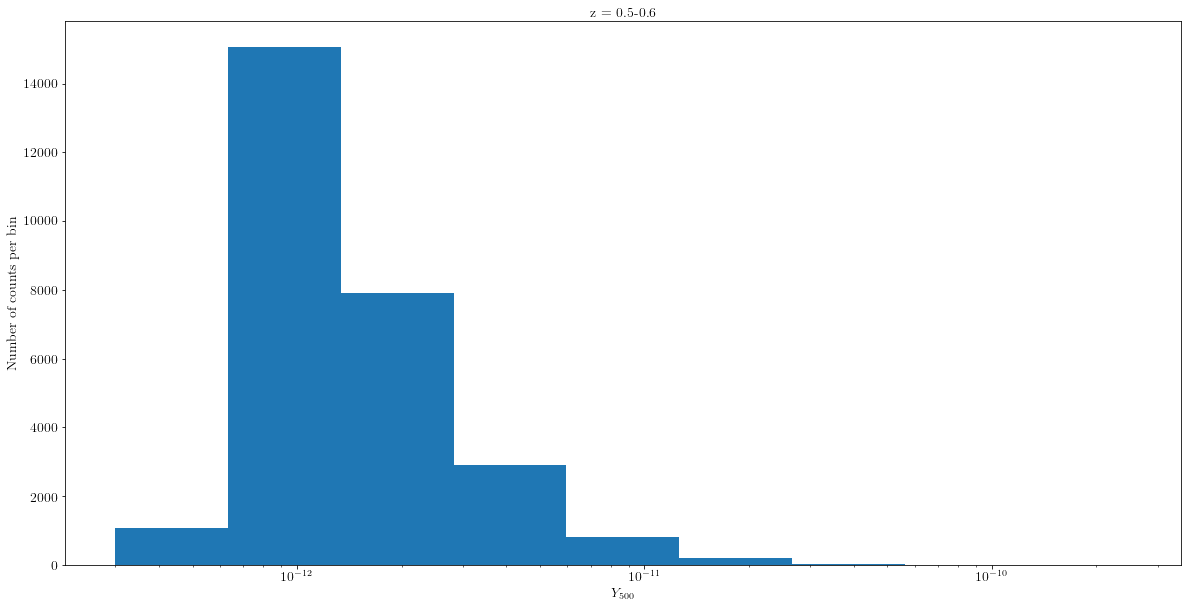

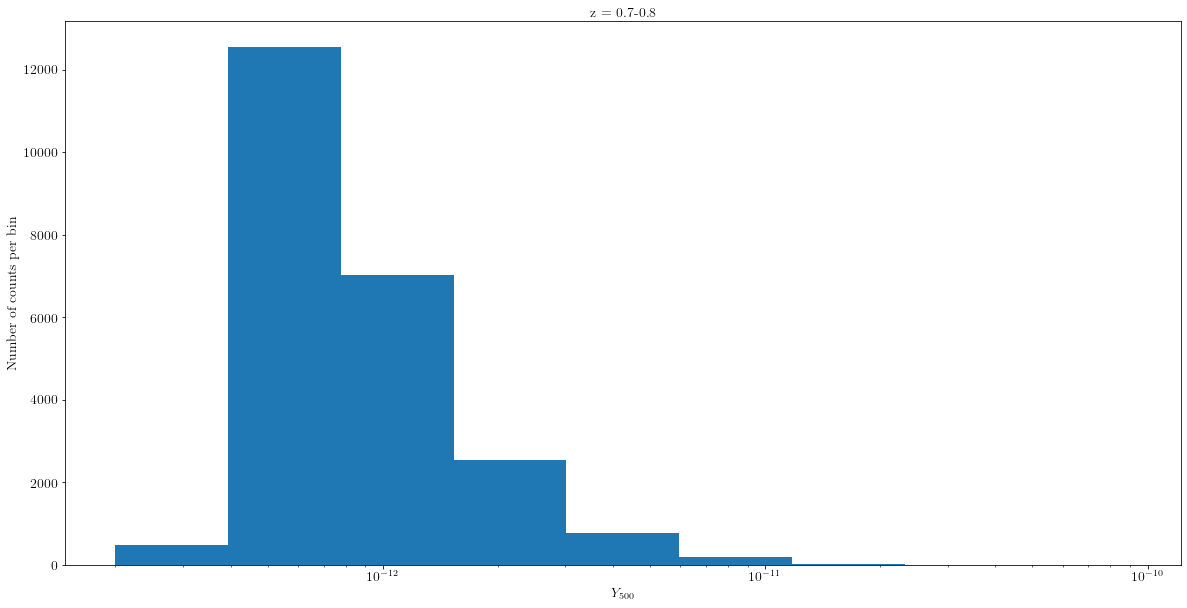

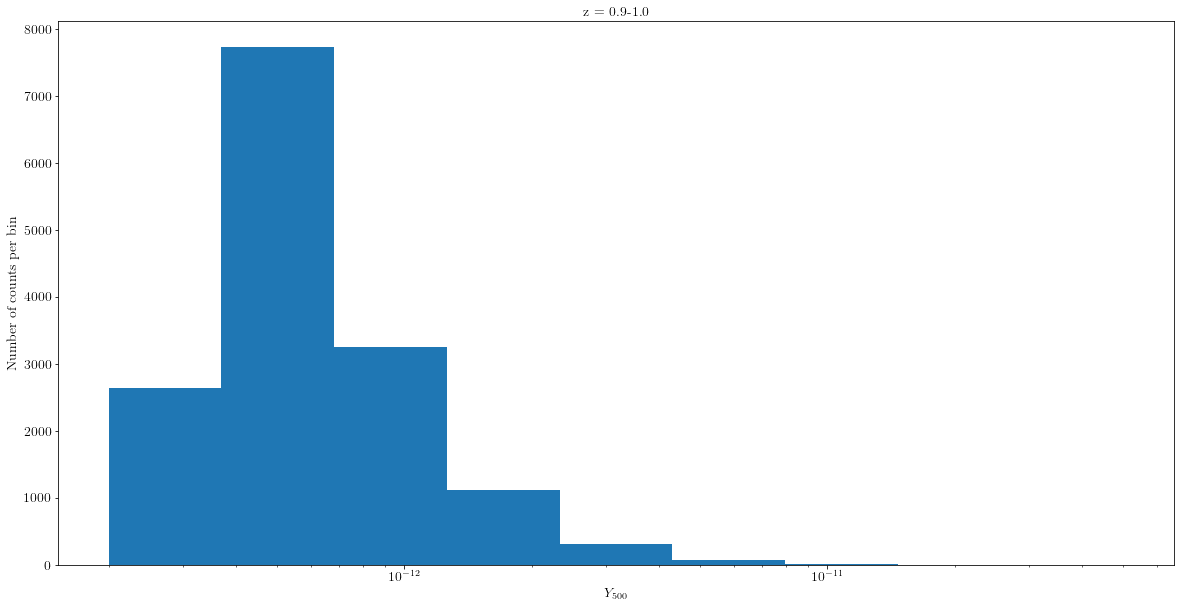

In [65]:
for i in range(5):
    plt.figure(figsize=(20,10))
    plt.hist(pairs_by_z[i][:, 1], bins=Y_bins_limits[i])
    plt.gca().set_xscale("log")
    plt.xlabel(r'$Y_{500}$')
    plt.ylabel('Number of counts per bin')
    plt.title('z = ' + str(np.around(z_min[i], 2)) + '-' + str(np.around(z_max[i], 2)))
    plt.show()

## Version 2

(1) Compute fiducial number of counts N for different redshift bins (for a range of masses, 14 to 15.5)

(2) Draw N samples from joint redshift-mass distribution

(3) Create mock catalogue

In [66]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v2_Y500_2 as n_counts_simulator_2

In [67]:
importlib.reload(n_counts_simulator_2)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v2_Y500_2' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params_mock_catalogue_v2_Y500_2.py'>

In [68]:
N_countsSimulator2 = n_counts_simulator_2.Model(log10masses, z_min, z_max)

In [69]:
N_countsSimulator2.N_counts

(array([ 7487.26774769, 22519.00909962, 27996.24759731, 23465.767297  ,
        15226.37143005]),
 pyccl.Cosmology(Omega_c=0.25141776937618154, Omega_b=0.04667086746481833, h=0.69, n_s=0.9655, sigma8=0.76, A_s=None, Omega_k=0, Omega_g=0, Neff=0, w0=-1, wa=0, T_CMB=2.7, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='bbks', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker', halo_concentration='duffy2008', emulator_neutrinos='strict'))

In [70]:
t1 = time.process_time()
zY_500_pairs = N_countsSimulator2.simulation(theta_fiducial_total, 1)
t2 = time.process_time()
print('time per 1 sim: ' + str(t2 -t1))

time per 1 sim: 20.913010283000006


In [71]:
pairs_by_z = [zY_500_pairs[(zY_500_pairs[:, 0] >= z_min[i]) & (zY_500_pairs[:, 0] <= z_max[i])] for i in range(len(z_min))]

In [72]:
for i in range(5):
    print(get_counts_by_M(pairs_by_z[i], Y_bins_limits[i]))

[210, 2625, 2862, 1192, 412, 139, 21, 5, 1]
[942, 11129, 6558, 2530, 918, 208, 46, 7, 1]
[1014, 15301, 7682, 2776, 852, 168, 31, 4, 0]
[529, 12557, 6873, 2460, 795, 166, 37, 3, 1]
[2558, 7965, 3171, 1096, 319, 71, 15, 2, 0]


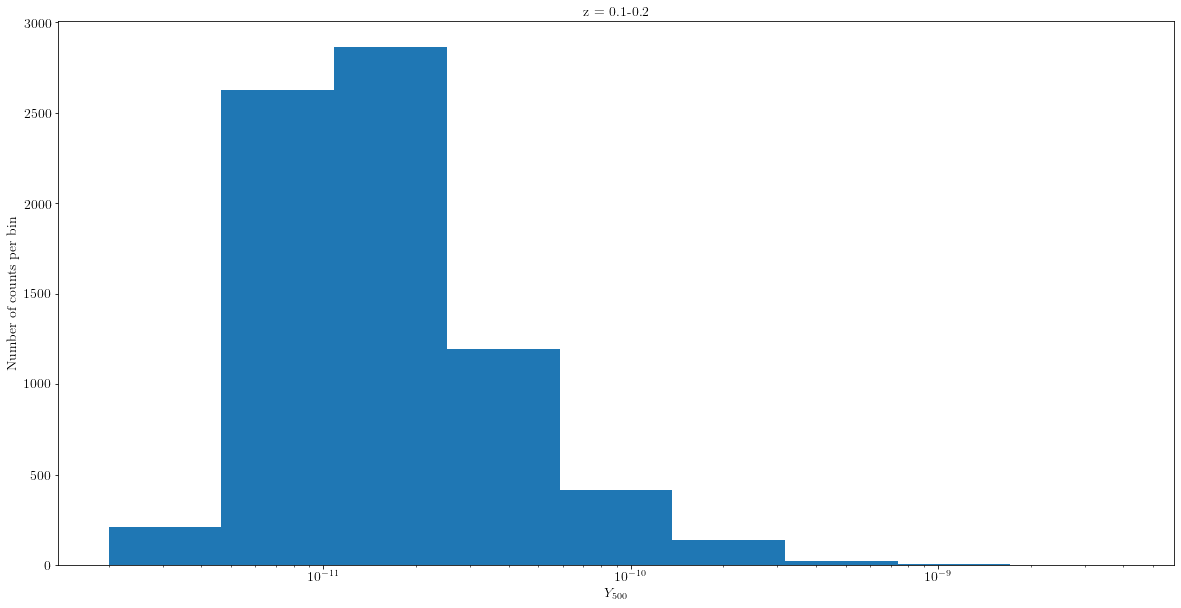

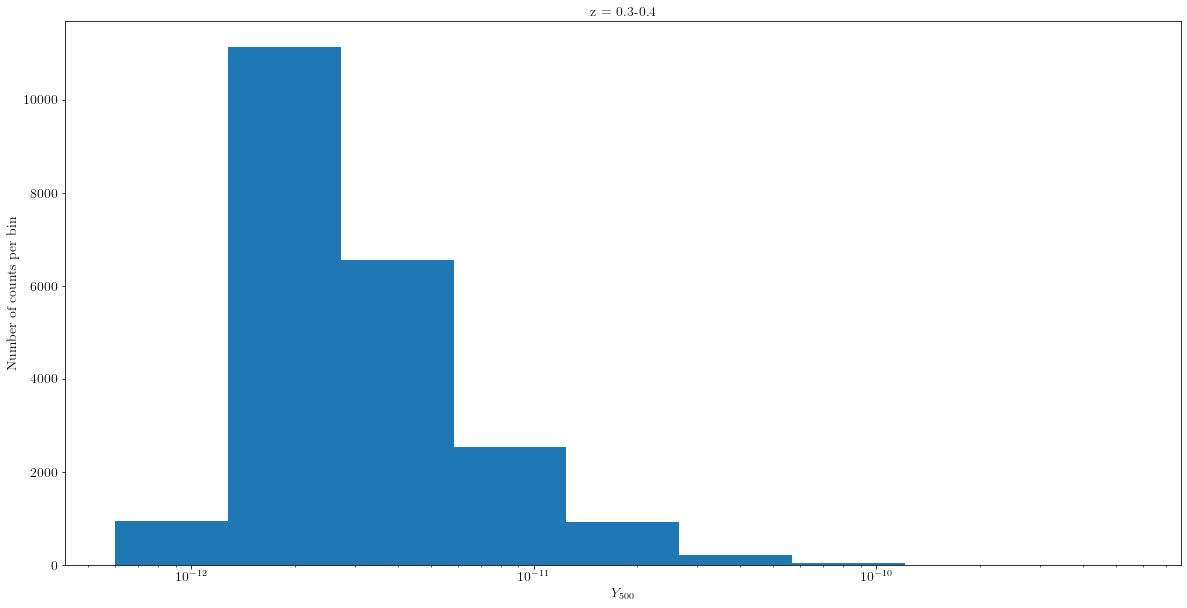

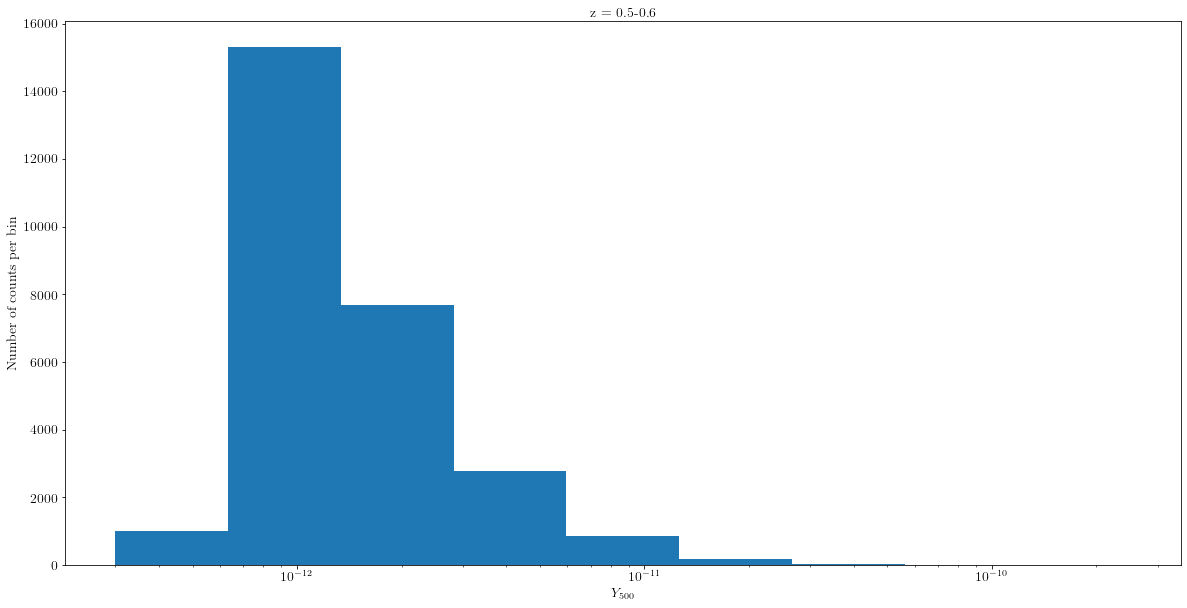

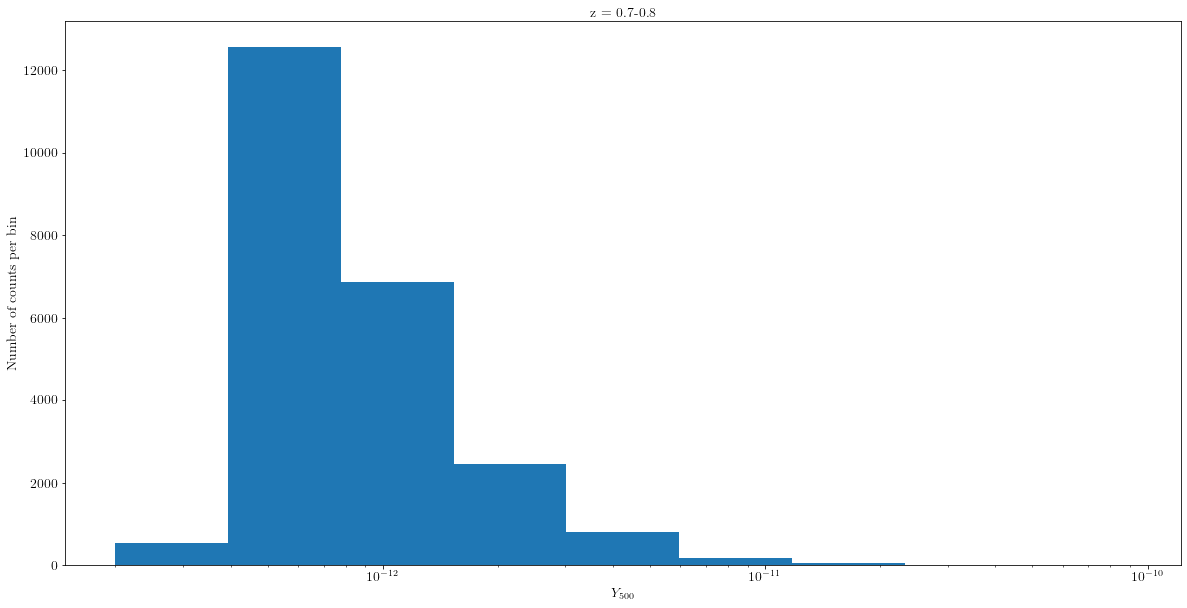

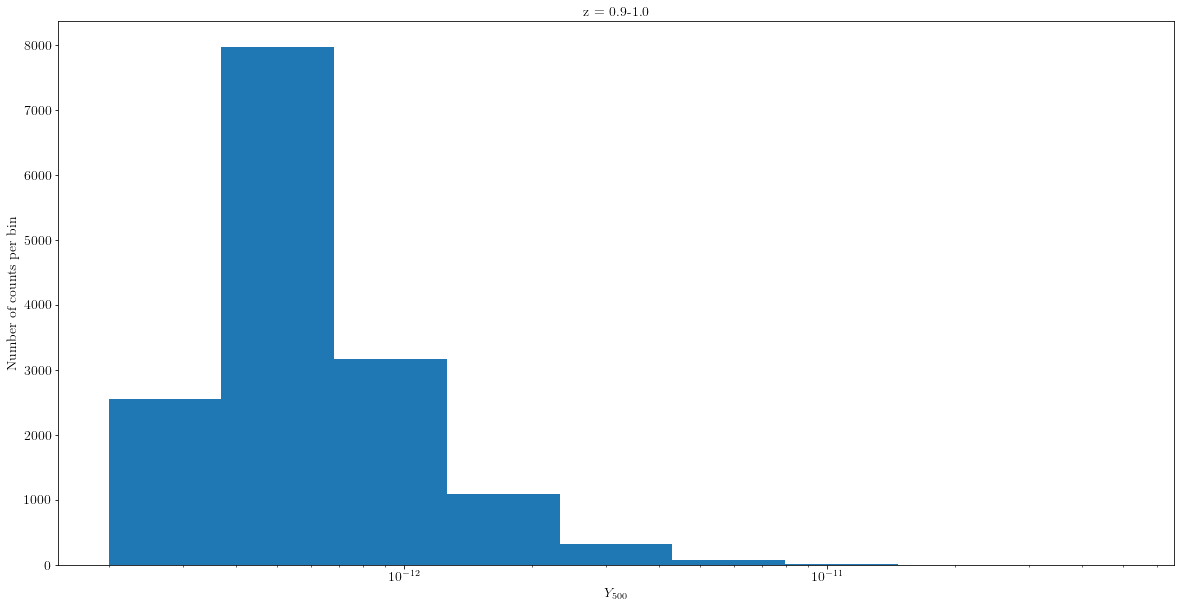

In [73]:
for i in range(5):
    plt.figure(figsize=(20,10))
    plt.hist(pairs_by_z[i][:, 1], bins=Y_bins_limits[i])
    plt.gca().set_xscale("log")
    plt.xlabel(r'$Y_{500}$')
    plt.ylabel('Number of counts per bin')
    plt.title('z = ' + str(np.around(z_min[i], 2)) + '-' + str(np.around(z_max[i], 2)))
    plt.show()